<a href="https://colab.research.google.com/github/PeterSlakhorst/colab_jupyter/blob/master/numpy_quant3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Source:  [Quantopian lecture](https://www.quantopian.com/lectures/introduction-to-numpy)

In [0]:
import numpy as np
import matplotlib.pyplot as plt

### Basic NumPy arrays

The most basic way that we could make use of NumPy in finance is calculating the mean return of a portfolio. Say that we have a list containing the historical return of several stocks.

In [3]:
stock_list = [3.5, 5, 2, 8, 4.2]
returns = np.array(stock_list)
print (returns, type(returns))

[3.5 5.  2.  8.  4.2] <class 'numpy.ndarray'>


You'll notice that the type of our array is 'ndarray', not just 'array'. This is because NumPy arrays can be created with multiple dimensions. If we pass np.array() a list of lists, it will create a 2-dimensional array. If we pass a list of lists of lists, it will create a 3-dimensional array, and so on and so forth.

In [5]:
A = np.array([[1, 2], [3, 4]])
print (A, type(A))

[[1 2]
 [3 4]] <class 'numpy.ndarray'>


We can access the dimensions of an array by looking at its `shape` member variable.

In [6]:
print (A.shape)

(2, 2)


Arrays are indexed in much the same way as lists in Python. Elements of a list begin indexing from $0$ and end at $n - 1$, where $n$ is the length of the array.

In [7]:
print (returns[0], returns[len(returns) - 1])
print(f'Alternatively: ', returns[-1])

3.5 4.2
Alternatively:  4.2


We can take a slice of an array using a colon, just like in a list.

In [8]:
print (returns[1:3])

[5. 2.]


A slice of an array, like in a list, will select a group of elements in the array starting from the first element indicated and going up to (but not including) the last element indicated.

In the case of multidimensional arrays, many of the same conventions with slicing and indexing hold. We can access the first column of a 2-dimensional array like so:

In [19]:
print (f'The first column of matrix A: { A[:, 0] } .')
print (f'The first row of matrix A: { A[0,:] } .')
print (f'Alternatively the first row of matrix A: { A[0] } .')
print (f'Access individual element of matrix A: { A[1,1] } .')

The first column of matrix A: [1 3] .
The first row of matrix A: [1 2] .
Alternatively the first row of matrix A: [1 2] .
Access individual element of matrix A: 4 .


#### Array functions

Functions built into NumPy can be easily called on arrays. Most functions are applied to an array element-wise (as scalar multiplication is). For example, if we call `log()` on an array, the logarithm will be taken of each element.

In [21]:
print (returns)
print (np.log(returns))
print (f'The mean of the array with returns: {np.mean(returns)}')

[3.5 5.  2.  8.  4.2]
[1.25276297 1.60943791 0.69314718 2.07944154 1.43508453]
The mean of the array with returns: 4.54


Let's simulate a universe of stocks using NumPy's functions. First we need to create the arrays to hold the assets and returns that we will use to build a portfolio. This is because arrays are created with a fixed size. Their dimensions can't be changed without creating a new array.

In [0]:
N = 10
assets = np.zeros((N, 100))
returns = np.zeros((N, 100))

This function, `zeroes()`, creates a NumPy array with the given dimensions that is entirely filled in with $0$. We can pass a single value or a tuple of as many dimensions as we like. Passing in the tuple `(N, 100)`, will return a two-dimensional array with $N$ rows and $100$ columns. Our result is a $N \times 100$ array.

Now we will simulate a base asset. We want the universe of stocks to be correlated with each other so we will use this initial value to generate the others.

In [0]:
R_1 = np.random.normal(1.01, 0.03, 100)
returns[0] = R_1
assets[0] = np.cumprod(R_1)

The `random` module in NumPy is exceedingly useful. It contains methods for sampling from many different probability distributions, some of which are covered in the [random variables lecture](https://www.quantopian.com/lectures/random-variables) in the Quantopian lecture series. In this case we draw $N = 100$ random samples from a normal distribution with mean $1.01$ and standard deviation $0.03$. We treat these as the daily percentage returns of our asset and take the cumulative product of these samples to get the current price.

The way we have generated our universe, the the individual $R_i$ vectors are each 1-dimensional arrays and the `returns` and `assets` variables contain 2-dimensional arrays. Above, we set the initial row of both `returns` and `assets` to be the first $R_i$ vector and the cumulative asset price based on those returns, respectively.

We will now use this base asset to create a few other random assets that are correlated with it.

In [0]:
# Generate assets that are correlated with R_1
for i in range(1, N):
    R_i = R_1 + np.random.normal(0.001, 0.02, 100)
    returns[i] = R_i # Set each row of returns equal to the new R_i array
    assets[i] = np.cumprod(R_i)
    
mean_returns = [(np.mean(R) - 1)*100 for R in returns]
return_volatilities = [np.std(R) for R in returns]

Here we generate the remaining $N - 1$ securities that we want in our universe by adding random noise to $R_1$. This ensures that our $N - 1$ other assets will be correlated with the base asset because they have some underlying information that is shared.

Let's plot what the mean return of each asset looks like:

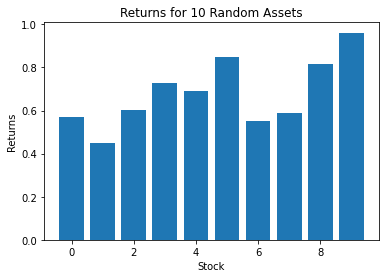

<Figure size 432x864 with 0 Axes>

In [35]:

plt.bar(np.arange(len(mean_returns)), mean_returns)
plt.xlabel('Stock')
plt.ylabel('Returns')
plt.title('Returns for {0} Random Assets'.format(N))
plt.figure(figsize=(6,12));

### Calculating Expected Return

So we have a universe of stocks. Great! Now let's put them together in a portfolio and calculate its expected return and risk.

We will start off by generating $N$ random weights for each asset in our portfolio.

In [0]:
weights = np.random.uniform(0, 1, N)
weights = weights/np.sum(weights)

We have to rescale the weights so that they all add up to $1$. We do this by scaling the weights vector by the sum total of all the weights. This step ensures that we will be using $100\%$ of the portfolio's cash.

To calculate the mean return of the portfolio, we have to scale each asset's return by its designated weight. We can pull each element of each array and multiply them individually, but it's quicker to use NumPy's linear algebra methods. The function that we want is `dot()`. This will calculate the dot product between two arrays for us. So if $v = \left[ 1, 2, 3 \right]$ and $w = \left[4, 5, 6 \right]$, then:

$$ v \cdot w = 1 \times 4 + 2 \times 5 + 3 \times 6 $$

For a one-dimensional vector, the dot product will multiply each element pointwise and add all the products together! In our case, we have a vector of weights, $\omega = \left[ \omega_1, \omega_2, \dots \omega_N\right]$ and a vector of returns, $\mu = \left[ \mu_1, \mu_2, \dots, \mu_N\right]$. If we take the dot product of these two we will get:

$$ \omega \cdot \mu = \omega_1\mu_1 + \omega_2\mu_2 + \dots + \omega_N\mu_N = \mu_P $$

This yields the sum of all the asset returns scaled by their respective weights. This the the portfolio's overall expected return!

In [37]:
p_returns = np.dot(weights, mean_returns)
print ("Expected return of the portfolio: ", p_returns)

Expected return of the portfolio:  0.6400771046040205


Calculating the mean return is fairly intuitive and does not require too much explanation of linear algebra. However, calculating the variance of our portfolio requires a bit more background.

#### Beware of NaN values

Most of the time, all of these calculations will work without an issue. However, when working with real data we run the risk of having `nan` values in our arrays. This is NumPy's way of saying that the data there is missing or doesn't exist. These `nan` values can lead to errors in mathematical calculations so it is important to be aware of whether your array contains `nan` values and to know how to drop them.

In [39]:
v = np.array([1, 2, np.nan, 4, 5])
print (v)

[ 1.  2. nan  4.  5.]


Let's see what happens when we try to take the mean of this array.

In [40]:
print np.mean(v)

SyntaxError: ignored

Clearly, `nan` values can have a large impact on our calculations. Fortunately, we can check for `nan` values with the `isnan()` function.

In [41]:
np.isnan(v)

array([False, False,  True, False, False])

Calling `isnan()` on an array will call the function on each value of the array, returning a value of `True` if the element is `nan` and `False` if the element is valid. Now, knowing whether your array contains `nan` values is all well and good, but how do we remove `nan`s? Handily enough, NumPy arrays can be indexed by boolean values (`True` or `False`). If we use a boolean array to index an array, we will remove all values of the array that register as `False` under the condition. We use the `isnan()` function in create a boolean array, assigning a `True` value to everything that is *not* `nan` and a `False` to the `nan`s and we use that to index the same array.

In [42]:
ix = ~np.isnan(v) # the ~ indicates a logical not, inverting the bools
print (v[ix]) # We can also just write v = v[~np.isnan(v)]

[1. 2. 4. 5.]


In [43]:
print (np.mean(v[ix]))

3.0


There are a few shortcuts to this process in the form of NumPy functions specifically built to handle them, such as `nanmean()`.

In [44]:
print (np.nanmean(v))

3.0


The `nanmean()` function simply calculates the mean of the array as if there were no `nan` values at all! There are a few more of these functions, so feel free to read more about them in the [documentation](https://docs.scipy.org/doc/numpy/user/index.html). These indeterminate values are more an issue with data than linear algebra itself so it is helpful that there are ways to handle them.

### Conclusion

Linear algebra is pervasive in finance and in general. For example, the calculation of *optimal* weights according to modern portfolio theory is done using linear algebra techniques. The arrays and functions in NumPy allow us to handle these calculations in an intuitive way. For a quick intro to linear algebra and how to use NumPy to do more significant matrix calculations, proceed to the next section.

## A brief foray into linear algebra

Let's start with a basic overview of some linear algebra. Linear algebra comes down to the multiplication and composition of scalar and matrix values. A scalar value is just a real number that we multiply against an array. When we scale a matrix or array using a scalar, we multiply each individual element of that matrix or array by the scalar.

A matrix is a collection of values, typically represented by an $m \times n$ grid, where $m$ is the number of rows and $n$ is the number of columns. The edge lengths $m$ and $n$ do not necessarily have to be different. If we have $m = n$, we call this a square matrix. A particularly interesting case of a matrix is when $m = 1$ or $n = 1$. In this case we have a special case of a matrix that we call a vector. While there is a matrix object in NumPy we will be doing everything using NumPy arrays because they can have dimensions greater than $2$. For the purpose of this section, we will be using matrix and array interchangeably.

We can express the matrix equation as:

$$ y = A\cdot x $$

Where $A$ is an $m \times n$ matrix, $y$ is a $m \times 1$ vector, and $x$ is a $n \times 1$ vector. On the right-hand side of the equation we are multiplying a matrix by a vector. This requires a little bit more clarification, lest we think that we can go about multiplying any matrices by any other matrices.

#### Matrix multiplication

With matrix multiplication, the order in which the matrices are multiplied matters. Multiplying a matrix on the left side by another matrix may be just fine, but multiplying on the right may be undefined.

In [0]:
A = np.array([
        [1, 2, 3, 12, 6],
        [4, 5, 6, 15, 20],
        [7, 8, 9, 10, 10]        
    ])
B = np.array([
        [4, 4, 2],
        [2, 3, 1],
        [6, 5, 8],
        [9, 9, 9]
    ])

Notice that the above-defined matrices, $A$ and $B$, have different dimensions. $A$ is $3 \times 5$ and $B$ is $4 \times 3$. The general rule of what can and cannot be multiplied in which order is based on the dimensions of the matrices. Specifically, the number of columns in the matrix on the left must be equal to the number of rows in the matrix on the right. In super informal terms, let's say that we have an $m \times n$ matrix and a $p \times q$ matrix. If we multiply the first by the second on the right, we get the following:

$$ (m \times n) \cdot (p \times q) = (m \times q) $$

So the resultant product has the same number of rows as the left matrix and the same number of columns as the right matrix. This limitation of matrix multiplication with regards to dimensions is important to keep track of when writing code. To demonstrate this, we use the `dot()` function to multiply our matrices below:

In [47]:
print (np.dot(A, B))

ValueError: ignored

These results make sense in accordance with our rule. Multiplying a $3 \times 5$ matrix on the right by a $4 \times 3$ matrix results in an error while multiplying a $4 \times 3$ matrix on the right by a $3 \times 5$ matrix results in a $4 \times 5$ matrix.

In [48]:
print (np.dot(B, A))

[[ 34  44  54 128 124]
 [ 21  27  33  79  82]
 [ 82 101 120 227 216]
 [108 135 162 333 324]]


### Portfolio Variance

Let's return to our portfolio example from before. We calculated the expected return of the portfolio, but how do we calculate the variance? We start by trying to evaluate the portfolio as a sum of each individual asset, scaled by it's weight.

$$ VAR[P] = VAR[\omega_1 S_1 + \omega_2 S_2 + \cdots + \omega_N S_N] $$

Where $S_0, \cdots, S_N$ are the assets contained within our universe. If all of our assets were independent of each other, we could simply evaluate this as

$$ VAR[P] = VAR[\omega_1 S_1] + VAR[\omega_2 S_2] + \cdots + VAR[\omega_N S_N] = \omega_1^2\sigma_1^2 + \omega_2^2\sigma_2^2 + \cdots + \omega_N^2\sigma_N^2 $$

However, all of our assets depend on each other by their construction. They are all in some way related to our base asset and therefore each other. We thus have to calculate the variance of the portfolio by including the individual pairwise covariances of each asset. Our formula for the variance of the portfolio:

$$ VAR[P] = \sigma_P^2 = \sum_i \omega_i^2\sigma_i^2 + \sum_i\sum_{i\neq j} \omega_i\omega_j\sigma_i\sigma_j\rho_{i, j}, \ i, j \in \lbrace 1, 2, \cdots, N \rbrace $$

Where $\rho_{i,j}$ is the correlation between $S_i$ and $S_j$, $\rho_{i, j} = \frac{COV[S_i, S_j]}{\sigma_i\sigma_j}$. This seems exceedingly complicated, but we can easily handle all of this using NumPy arrays. First, we calculate the covariance matrix that relates all the individual stocks in our universe.

In [49]:
cov_mat = np.cov(returns)
print (cov_mat)

[[0.00090815 0.00078744 0.00098109 0.00088966 0.00085615 0.00090198
  0.00089856 0.00087965 0.00085997 0.00091255]
 [0.00078744 0.00106443 0.00086733 0.00076001 0.00073633 0.00076813
  0.00079374 0.00080717 0.00079533 0.00076027]
 [0.00098109 0.00086733 0.00138929 0.0009519  0.00096812 0.00100411
  0.00091911 0.00090126 0.00092155 0.00101335]
 [0.00088966 0.00076001 0.0009519  0.00129933 0.00087473 0.0009401
  0.00087829 0.00078776 0.0007932  0.00087252]
 [0.00085615 0.00073633 0.00096812 0.00087473 0.00126499 0.00088463
  0.00080661 0.00079539 0.00081893 0.00084997]
 [0.00090198 0.00076813 0.00100411 0.0009401  0.00088463 0.00127732
  0.00084304 0.00094105 0.00085149 0.00094157]
 [0.00089856 0.00079374 0.00091911 0.00087829 0.00080661 0.00084304
  0.00139553 0.00094568 0.00091761 0.00093691]
 [0.00087965 0.00080717 0.00090126 0.00078776 0.00079539 0.00094105
  0.00094568 0.00127313 0.00084903 0.00096015]
 [0.00085997 0.00079533 0.00092155 0.0007932  0.00081893 0.00085149
  0.00091761 

This array is not formatted particularly nicely, but a covariance matrix is a very important concept. The covariance matrix is of the form:

$$ \left[\begin{matrix}
VAR[S_1] & COV[S_1, S_2] & \cdots & COV[S_1, S_N] \\
COV[S_2, S_1] & VAR[S_2] & \cdots & COV[S_2, S_N] \\
\vdots & \vdots & \ddots & \vdots \\
COV[S_N, S_1] & COV[S_N, S_2] & \cdots & VAR[S_N]
\end{matrix}\right] $$

So each diagonal entry is the variance of that asset at that index and each off-diagonal holds the covariance of two assets indexed by the column and row number. What is important is that once we have the covariance matrix we are able to do some very quick linear algebra to calculate the variance of the overall portfolio. We can represent the variance of the portfolio in array form as:

$$ \sigma_p^2 = \omega \ C \ \omega^\intercal$$

Where $C$ is the covariance matrix of all the assets and $\omega$ is the array containing the weights of each individual asset. The superscript $\intercal$ on the second $\omega$ listed above denotes the **transpose** of $\omega$. For a reference on the evaluation of the variance of a portfolio as a matrix equation, please see the Wikipedia article on [modern portfolio theory](https://en.wikipedia.org/wiki/Modern_portfolio_theory).

The transpose of an array is what you get when you switch the rows and columns of an array. This has the effect of reflecting an array across what you might imagine as a diagonal. For example, take our array $A$ from before:

In [50]:
print (A)

[[ 1  2  3 12  6]
 [ 4  5  6 15 20]
 [ 7  8  9 10 10]]


The transpose looks like a mirror image of the same array.

In [51]:
print (np.transpose(A))

[[ 1  4  7]
 [ 2  5  8]
 [ 3  6  9]
 [12 15 10]
 [ 6 20 10]]


But $\omega$ here is a 1-dimensional array, a vector! It makes perfect to take the transpose of $A$, a $3 \times 5$ array, as the output will be a $5 \times 3$ array, but a 1-dimensional array is not quite as intuitive. A typical 1-dimensional array can be thought of as a $1 \times n$ horizontal vector. Thus, taking the tranpose of this array essentially means changing it into a $n \times 1$ vertical vector. This makes sense because 1-dimensional arrays are still arrays and any multiplication done between 1-dimensional and higher dimensional arrays must keep in line with our dimensionality issue of matrix multiplication.

To make a long story short, we think of $\omega$ as $1 \times N$ since we have $N$ securities. This makes it so that $\omega^\intercal$ is $N \times 1$. Again, our covariance matrix is $N \times N$. So the overall multiplication works out like so, in informal terms:

$$ \text{Dimensions}(\sigma_p^2) = \text{Dimensions}(\omega C \omega^\intercal) = (1 \times N)\cdot (N \times N)\cdot (N \times 1) = (1 \times 1)$$

Multiplying the covariance matrix on the left by the plain horizontal vector and on the right by that vector's transpose results in the calculation of a single scalar ($1 \times 1$) value, our portfolio's variance.

So knowing this, let's proceed and calculate the portfolio variance! We can easily calculate the product of these arrays by using `dot()` for matrix multiplication, though this time we have to do it twice.

In [52]:
# Calculating the portfolio volatility
var_p = np.dot(np.dot(weights, cov_mat), weights.T)
vol_p = np.sqrt(var_p)
print ("Portfolio volatility: ", vol_p)

Portfolio volatility:  0.030550541548775217


To confirm this calculation, let's simply evaluate the volatility of the portfolio using only NumPy functions.

In [53]:
# Confirming calculation
vol_p_alt = np.sqrt(np.var(np.dot(weights, returns), ddof=1))
print ("Portfolio volatility: ", vol_p_alt)

Portfolio volatility:  0.030550541548775244


The `ddof` parameter is a simple integer input that tells the function the number of degrees of freedom to take into account. This is a more statistical concept, but what this tells us that our matrix calculation is correct!

A lot of this might not make sense at first glance. It helps to go back and forth between the theory and the code representations until you have a better grasp of the mathematics involved. It is definitely not necessary to be an expert on linear algebra and on matrix operations, but linear algebra can help to streamline the process of working with large amounts of data. For further reading on NumPy, check out the [documentation](https://docs.scipy.org/doc/numpy/user/index.html).

*This presentation is for informational purposes only and does not constitute an offer to sell, a solicitation to buy, or a recommendation for any security; nor does it constitute an offer to provide investment advisory or other services by Quantopian, Inc. ("Quantopian"). Nothing contained herein constitutes investment advice or offers any opinion with respect to the suitability of any security, and any views expressed herein should not be taken as advice to buy, sell, or hold any security or as an endorsement of any security or company.  In preparing the information contained herein, Quantopian, Inc. has not taken into account the investment needs, objectives, and financial circumstances of any particular investor. Any views expressed and data illustrated herein were prepared based upon information, believed to be reliable, available to Quantopian, Inc. at the time of publication. Quantopian makes no guarantees as to their accuracy or completeness. All information is subject to change and may quickly become unreliable for various reasons, including changes in market conditions or economic circumstances.*